>## research paper: [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929)

In [4]:
import torch
import torchvision
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print(f"helper_functions.py already exists, skipping download...")
else:
    print(f"downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as file:
        file.write(request.content)

helper_functions.py already exists, skipping download...


In [6]:
import helper_functions

image_path = helper_functions.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                               destination="pizza_steak_sushi",
                               remove_source=True)
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [8]:
!git clone https://github.com/stanleyedward/pytorch_modules.git

fatal: destination path 'pytorch_modules' already exists and is not an empty directory.


In [9]:
from pytorch_modules.modules import data_preprocess
from torchvision import transforms
#create image size( table 3 of vit paper)
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])
print(f"manually creaated transforms: {manual_transforms}")

manually creaated transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [10]:
#craete a batchsize of 32 (even tho paper uses 4096 we dont have hardware for it)
BATCH_SIZE = 32
train_dataloader, test_dataloader, class_names = data_preprocess.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

In [11]:
### visualize a single image
#get a batch of imge
image_batch, label_batch = next(iter(train_dataloader))
#get a single img and abel form the batch
image, label = image_batch[0], label_batch[0]

#view the abtch shapes
print(f"train_dataloader_batchshape: {image_batch.shape}")

#view the single img shape
image.shape, label

train_dataloader_batchshape: torch.Size([32, 3, 224, 224])


(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

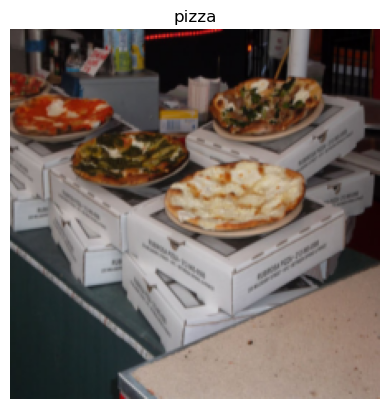

In [12]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1,2,0)) #as matplotlib takes CHW
plt.title(class_names[label])
plt.axis("off")

# overview of the paper
- figure 1: viual overview of the architecture
- four equations: math equations which define the function ofeach layer/block
- table 1/3: diffrente hyperparamters for the architecture/trianing.
- text

### figure 1
![Alt text](image-2.png)
* embedding - learnable representation (start with random numbers and improve them overtime) 
* mlp = multilevel perceptron



### four equations
![Alt text](image-1.png)

Equaion1:
* embedding - learnable representation (start with random numbers and improve them overtime) 
* path embeddings - patches of original image - pink
* position embeddings - to retain positional information -  purple
* class token embedding - to perform classification (*/pink)

```python
x_input = [learnable_class_token, image_patch_embeddings_1, image_patch_embeddings_2,...image_patch_embeddings_N]+
            [learnable_class_token_pos, image_patch_1_embeddings_pos, image_patch_2_embeddings_pos,...image_patch_N_embeddings_pos]
```

Equation2:
* MSA = Multi-Head self attention (Multi-Head Attension)
* LN = LayerNorm (Norm))
* zv(l-1) = input before LN block, adding residual connections (+)

```python
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input 

```

Equation3:
* MLP = MultiLayer Perceptron
* LN = LayerNorm
* z'v(l) = input before LN block, adding residual connections (+)

```python
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```

Equation4:
* MLP = MultiLayer Perceptron - a nerual network with x no. of layers
* MLP = one hidden layer at training time
* MLP = single linear layer in fine-tuning time
* LN = LayerNorm

```python
y = Linear_layer(LN_layer(x_output_MLP_block)) 
```
or
```python
y = MLP(LN_layer(x_output_MLP_block)) 
```


### table 1/3:
![Alt text](image-3.png)

#### all different sizes of the same model
#### ViT-B/16 - ViT-Base with image patch size 16x16

* layers = no. of transformers encoder layers
* hidden size $D$  - the embedding size throughout the architecture

                    - if we have embedding size of 768 means 

                    - each image patch that may be 16x16 

                    - is turned into a vector of size 768

                    - learnable vector*
                    
* MLP size - no. of hidden units/neurons in the MLP

            - if the MLP size is 3072 
            - then the no of hidden units in the MLP layer in 3072

* Heads - the number of heads within multihead self-attention layers

        - if heads = 12 we have 12 heads in MSA layer
        
> ![Alt text](image-4.png)
        
        - denoted by h



### text

## equatinon1: split data into patches and creating the class, position and patch embedding 

### layers = input -> function -> output 

* what's the input shape?
* whats the output shape?

one of the biggest porblems in dl are misaligned tensor shapes

* Input shape: (224,224) -> single image -> (height, width, color channels)
* Output shape: 

* Input shape: $H*W*C$ [hieight,width, color channels]
* output shape: $N\times(P^2*C)$
- H = height
- W = width
- C = Color channels
- P = patchs ize
- N = number of patches = (height*width)/p^2
- D =  constant latent vector size = embedding dimension (see table 1)

In [13]:
# exmaple values 
height = 224
width = 224
color_channels = 3
patch_size = 16

#calc the number of patches
num_patches = int((height *width) / (patch_size**2)) 
num_patches

196

In [14]:
#input shape
embedding_layer_input_shape = (height, width, color_channels)

#otput shape
embedding_layer_output_shape = (num_patches, patch_size**2 * color_channels)

print(f"input shape( single@D iamge): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of pathces): {embedding_layer_output_shape}")

input shape( single@D iamge): (224, 224, 3)
Output shape (single 1D sequence of pathces): (196, 768)


* Input shape: (224,224) -> single image -> (height, width, color channels)
* Output shape: (196,768) -> (number of patches, embedding_dimension)   ; embedding dimension = $D$ from table 1

## turning a single image into patches

(-0.5, 223.5, 223.5, -0.5)

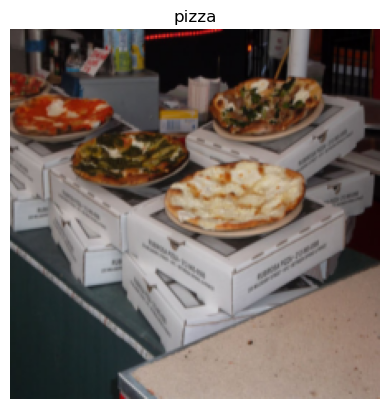

In [18]:
#view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off")

In [16]:
image.shape

torch.Size([3, 224, 224])